In [1]:
!pip install scikit-learn==1.2.2
!pip install imbalanced-learn==0.12.4

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
import os
import re

def natural_sort_key(text):
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'([0-9]+)', text)]

def explore_dataset(base_path):
    folder_stats = []

    def list_folders_recursive(path, indent=0):
        folder_name = os.path.basename(path) or path
        image_files = [
            f for f in os.listdir(path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))
        ]
        folder_stats.append((folder_name, len(image_files), path))

        print("   " * indent + f"📁 {folder_name} — 🖼️ {len(image_files)} images")

        for f in sorted(os.listdir(path), key=natural_sort_key):
            full_path = os.path.join(path, f)
            if os.path.isdir(full_path):
                list_folders_recursive(full_path, indent + 1)

    list_folders_recursive(base_path)

    total_images = sum(count for _, count, _ in folder_stats)

    max_name_len = max(len(name) for name, _, _ in folder_stats) + 2

    print("\n" + "=" * 70)

# Example usage
explore_dataset('/kaggle/input/skin-cancer-mnist-ham10000')

📂 Exploring dataset structure in: /kaggle/input/skin-cancer-mnist-ham10000
📁 skin-cancer-mnist-ham10000 — 🖼️ 0 images
   📁 HAM10000_images_part_1 — 🖼️ 5000 images
   📁 ham10000_images_part_1 — 🖼️ 5000 images
   📁 HAM10000_images_part_2 — 🖼️ 5015 images
   📁 ham10000_images_part_2 — 🖼️ 5015 images



### **1. Load Dataset**

In [3]:
# ======================================================
# 1. Load Dataset
# ======================================================
csv_path = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
df = pd.read_csv(csv_path)

labels = df["label"].values
data = df.drop(columns=["label"]).values

### **2. Handle imbalance using RandomOverSampler**

✅ Data shape: (46935, 3, 28, 28)
✅ Label distribution after oversampling:


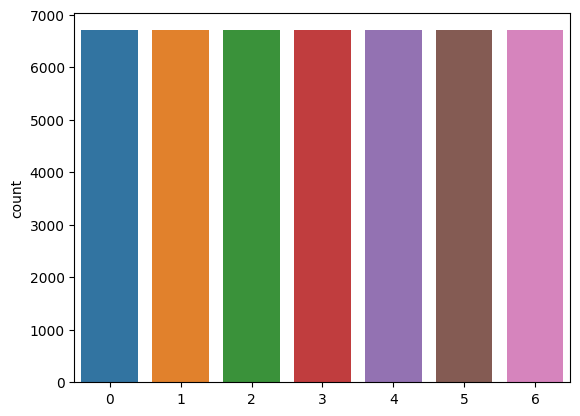

In [4]:
# ======================================================
# 2. Handle imbalance using RandomOverSampler
# ======================================================
oversample = RandomOverSampler()
data_res, labels_res = oversample.fit_resample(data, labels)

# Reshape to images (28x28x3)
data_res = np.array(data_res).reshape(-1, 3, 28, 28)
data_res = data_res / 255.0  # Normalize 0-1

print("✅ Data shape:", data_res.shape)
print("✅ Label distribution after oversampling:")
sns.countplot(x=labels_res)
plt.show()

### **3. Split data**

In [5]:
# ======================================================
# 3. Split data
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    data_res, labels_res, test_size=0.25, random_state=49
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, drop_last=True)

### **4. Build CNN model**

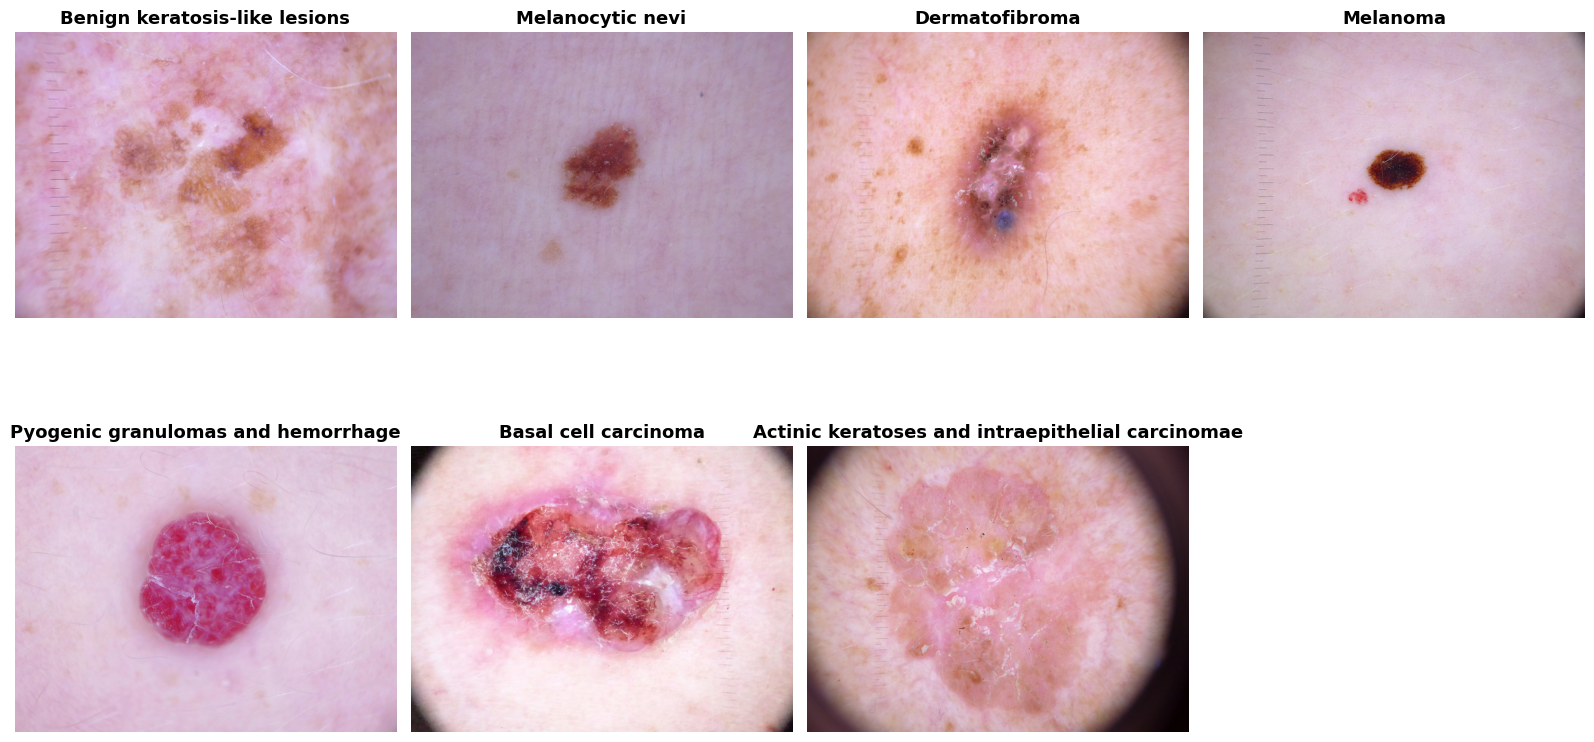

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Paths
meta_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
img_dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
img_dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

# Load metadata
df = pd.read_csv(meta_path)

# Combine image paths from both parts
df["image_path"] = df["image_id"].apply(lambda x: 
    os.path.join(img_dir_1, f"{x}.jpg") if os.path.exists(os.path.join(img_dir_1, f"{x}.jpg"))
    else os.path.join(img_dir_2, f"{x}.jpg")
)

# Class dictionary
classes = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'vasc': 'Pyogenic granulomas and hemorrhage',
    'akiec': 'Actinic keratoses and intraepithelial carcinomae',
    'df': 'Dermatofibroma'
}

# Display one sample image from each class with clear title
plt.figure(figsize=(16, 9))
unique_classes = df["dx"].unique()

for i, cls in enumerate(unique_classes):
    sample = df[df["dx"] == cls].iloc[0]
    img_path = sample["image_path"]
    img = Image.open(img_path)

    plt.subplot(2, (len(unique_classes)+1)//2, i+1)
    plt.imshow(img)
    plt.title(classes.get(cls, cls), fontsize=13, fontweight='bold')
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# ======================================================
# 4. Build CNN model
# ======================================================
class SkinCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256 * 1 * 1, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SkinCNN(num_classes=7).to(device)
print(model)

SkinCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

### **5. Loss, Optimizer, Scheduler**

In [8]:
# ======================================================
# 5. Loss, Optimizer, Scheduler
# ======================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### **6. Training**

In [ ]:
# ======================================================
# 6. Training
# ======================================================
def train_model(model, train_loader, test_loader, epochs=25):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (pred == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss /= len(test_loader)
        scheduler.step(val_acc)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: TrainAcc={train_acc:.2f}% ValAcc={val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "model.pth")

    return history


history = train_model(model, train_loader, test_loader, epochs=25)

Epoch 1/25: 100%|██████████| 275/275 [00:04<00:00, 56.35it/s]


Epoch 1: TrainAcc=56.31% ValAcc=74.84%


Epoch 2/25: 100%|██████████| 275/275 [00:02<00:00, 95.03it/s]


Epoch 2: TrainAcc=78.27% ValAcc=67.26%


Epoch 3/25: 100%|██████████| 275/275 [00:02<00:00, 95.65it/s]


Epoch 3: TrainAcc=86.43% ValAcc=53.22%


Epoch 4/25: 100%|██████████| 275/275 [00:02<00:00, 94.25it/s]


Epoch 4: TrainAcc=89.31% ValAcc=81.77%


Epoch 5/25: 100%|██████████| 275/275 [00:02<00:00, 94.83it/s]


Epoch 5: TrainAcc=92.18% ValAcc=88.02%


Epoch 6/25: 100%|██████████| 275/275 [00:02<00:00, 93.69it/s]


Epoch 6: TrainAcc=93.40% ValAcc=70.63%


Epoch 7/25: 100%|██████████| 275/275 [00:02<00:00, 95.18it/s]


Epoch 7: TrainAcc=94.86% ValAcc=65.99%


Epoch 8/25: 100%|██████████| 275/275 [00:02<00:00, 93.81it/s]


Epoch 8: TrainAcc=94.80% ValAcc=91.73%


Epoch 9/25: 100%|██████████| 275/275 [00:02<00:00, 92.05it/s]


Epoch 9: TrainAcc=97.13% ValAcc=95.19%


Epoch 10/25: 100%|██████████| 275/275 [00:02<00:00, 94.61it/s]


Epoch 10: TrainAcc=96.67% ValAcc=94.87%


Epoch 11/25: 100%|██████████| 275/275 [00:02<00:00, 95.46it/s]


Epoch 11: TrainAcc=97.67% ValAcc=94.98%


Epoch 12/25: 100%|██████████| 275/275 [00:02<00:00, 94.38it/s]


Epoch 12: TrainAcc=97.74% ValAcc=91.68%


Epoch 13/25: 100%|██████████| 275/275 [00:02<00:00, 93.74it/s]


Epoch 13: TrainAcc=99.32% ValAcc=97.87%


Epoch 14/25: 100%|██████████| 275/275 [00:02<00:00, 93.79it/s]


Epoch 14: TrainAcc=99.66% ValAcc=97.62%


Epoch 15/25: 100%|██████████| 275/275 [00:02<00:00, 92.49it/s]


Epoch 15: TrainAcc=99.55% ValAcc=96.94%


Epoch 16/25: 100%|██████████| 275/275 [00:02<00:00, 93.31it/s]


Epoch 16: TrainAcc=99.45% ValAcc=96.75%


Epoch 17/25: 100%|██████████| 275/275 [00:02<00:00, 92.77it/s]


Epoch 17: TrainAcc=99.78% ValAcc=97.99%


Epoch 18/25: 100%|██████████| 275/275 [00:02<00:00, 91.75it/s]


Epoch 18: TrainAcc=99.96% ValAcc=98.07%


Epoch 19/25: 100%|██████████| 275/275 [00:02<00:00, 92.61it/s]


Epoch 19: TrainAcc=99.96% ValAcc=98.44%


Epoch 20/25: 100%|██████████| 275/275 [00:02<00:00, 92.93it/s]


Epoch 20: TrainAcc=99.98% ValAcc=97.65%


Epoch 21/25: 100%|██████████| 275/275 [00:02<00:00, 91.82it/s]


Epoch 21: TrainAcc=99.83% ValAcc=98.02%


Epoch 22/25: 100%|██████████| 275/275 [00:02<00:00, 93.47it/s]


Epoch 22: TrainAcc=99.80% ValAcc=97.81%


Epoch 23/25: 100%|██████████| 275/275 [00:03<00:00, 91.12it/s]


Epoch 23: TrainAcc=99.89% ValAcc=97.93%


Epoch 24/25: 100%|██████████| 275/275 [00:03<00:00, 90.42it/s]


Epoch 24: TrainAcc=99.99% ValAcc=98.08%


Epoch 25/25: 100%|██████████| 275/275 [00:02<00:00, 92.02it/s]


Epoch 25: TrainAcc=99.98% ValAcc=98.00%


### **7. Evaluation**


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1649
           1       0.99      1.00      0.99      1678
           2       0.97      1.00      0.98      1641
           3       1.00      1.00      1.00      1616
           4       0.99      0.91      0.95      1649
           5       1.00      1.00      1.00      1671
           6       0.95      0.99      0.97      1744

    accuracy                           0.98     11648
   macro avg       0.98      0.98      0.98     11648
weighted avg       0.98      0.98      0.98     11648



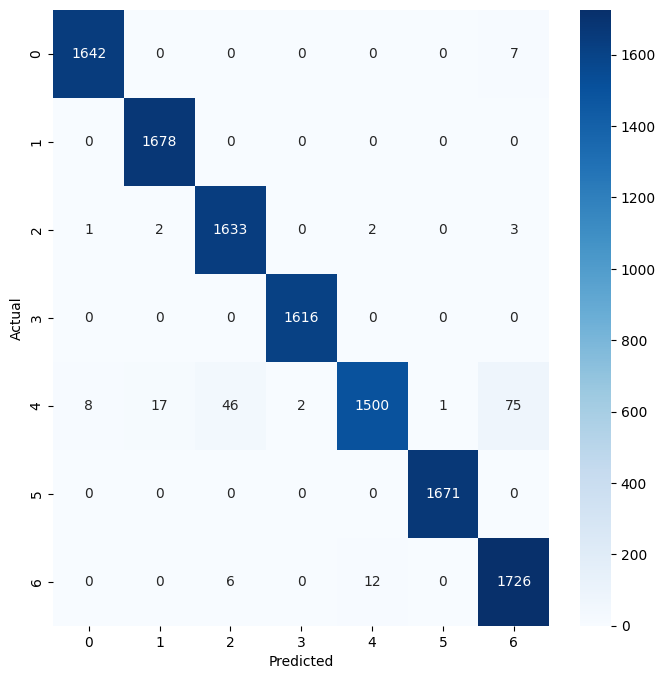

In [ ]:
# ======================================================
# 7. Evaluation
# ======================================================
model.load_state_dict(torch.load("model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### **8. Training Curves**

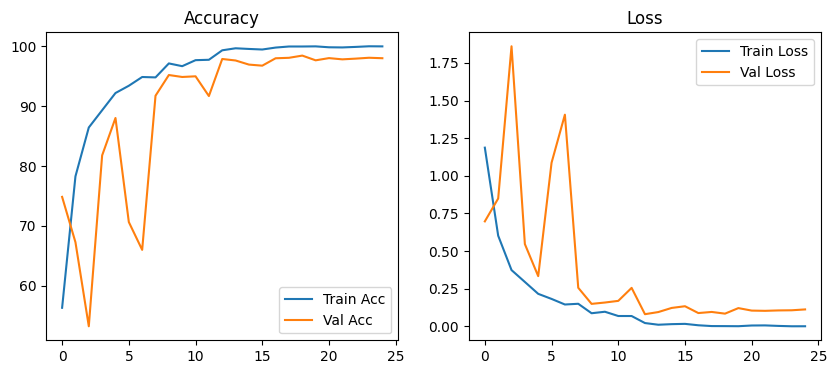

In [11]:
# ======================================================
# 8. Training Curves
# ======================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [12]:
# Convert model to TorchScript
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("skin_cnn_torchscript.pt")

### **🔍 Test the trained CNN model on a single image**

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# ======================================================
# Define the CNN model (adaptive version)
# ======================================================
class SkinCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256 * 1 * 1, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


# ======================================================
# Define class labels
# ======================================================
classes = {
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'Basal cell carcinoma'),
    2: ('bkl', 'Benign keratosis-like lesions'),
    3: ('df', 'Dermatofibroma'),
    4: ('nv', 'Melanocytic nevi'),
    5: ('vasc', 'Pyogenic granulomas and hemorrhage'),
    6: ('mel', 'Melanoma')
}


# ======================================================
# Prediction function
# ======================================================
def predict_skin_disease(img_path, model_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = SkinCNN(num_classes=7).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    
    idx = pred.item()
    short_name, full_name = classes[idx]
    
    return short_name, full_name


# ======================================================
# Example usage
# ======================================================
img_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0029312.jpg"
model_path = "/kaggle/working/model.pth"

short_name, full_name = predict_skin_disease(img_path, model_path)
print(f"Predicted Class: {short_name} → {full_name}")

Predicted Class: nv → Melanocytic nevi
